In [281]:
#import libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [282]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [283]:
stop_words = set(stopwords.words('english'))
domain_words = {
    "klia", "airport"
}
stop_words.update(domain_words)

In [284]:
lemmatizer = WordNetLemmatizer()

In [285]:
def handle_negation(text):
    # Simple negation handling
    text = re.sub(r"\bnot\b\s+(\w+)", r"not_\1", text)
    text = re.sub(r"\bno\b\s+(\w+)", r"no_\1", text)
    return text

In [286]:
def get_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

In [ ]:
def preprocess(text):
    """Normalize, clean, tokenize, remove stopwords, and lemmatize text."""
    if not isinstance(text, str):
        return ""
    
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    
    # Detect comparative statements about OTHER airports
    # Pattern: "send/go to X ... best/excellent" 
    text = re.sub(r'(send|go|fly).{0,100}?(best|excellent|better)\s+(airport|terminal)', 
                  r'COMPARING_TO_BETTER_AIRPORT', text)
    
    # Pattern: "next door/neighbor ... best/excellent"
    text = re.sub(r'(next door|neighbor|neighbouring).{0,60}?(best|excellent|better)', 
                  r'COMPARING_TO_BETTER_AIRPORT', text)
    
    # Mark "run the best" separately (since it's about another airport)
    text = re.sub(r'run.{0,20}?(best|excellent)\s+airport', 
                  r'COMPARING_TO_BETTER_AIRPORT', text)
    
    # Negation handling BEFORE removing punctuation
    text = re.sub(r"\bnot\b\s+(\w+)", r"not_\1", text)
    text = re.sub(r"\bno\b\s+(\w+)", r"no_\1", text)
    
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(tok, get_pos(tag))
        for tok, tag in tagged
        if tok not in stop_words
    ]
    
    return " ".join(lemmas)

In [288]:
df = pd.read_csv("cleaned_training_data.csv")
print("Columns in CSV:", df.columns.tolist())
print(df.head())

Columns in CSV: ['TEXT', 'processed_text', 'SENTIMENT']
                                                TEXT  \
0                 poor wifi at food court Ridiculous   
1  The queue for hours feels like an old-school a...   
2  My recent experience at Kuala Lumpur Internati...   
3  Very slow immigration service at depature and ...   
4  Gate C is too far away, and the security check...   

                                      processed_text SENTIMENT  
0                    poor wifi food court ridiculous  Negative  
1                     queue hour feel like oldschool  Negative  
2  recent experience kuala lumpur international n...  Negative  
3  slow immigration service depature arrival time...  Negative  
4  gate c far away security check front gate shor...  Negative  


In [289]:
# Remove rows where processed_text is NaN or empty
print(f"Before removing NaN: {len(df)}")
df = df.dropna(subset=['processed_text'])
df = df[df['processed_text'].str.strip() != '']
print(f"After removing NaN: {len(df)}")

Before removing NaN: 2397
After removing NaN: 2396


In [290]:
# Check class distribution
print("\nClass distribution:")
print(df['SENTIMENT'].value_counts())


Class distribution:
SENTIMENT
Negative    1383
Positive     845
Neutral      168
Name: count, dtype: int64


In [291]:
# TRAIN /test split
X = df['processed_text']
y = df['SENTIMENT']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [292]:
#TF-IDF Vectorixer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [293]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print(f"TF-IDF vectorizer saved with {X_train_tfidf.shape[1]} features")

TF-IDF vectorizer saved with 5000 features


In [294]:
#train model

base_svm = LinearSVC(random_state=42, max_iter=10000)
svm = CalibratedClassifierCV(base_svm, cv=3)
svm.fit(X_train_tfidf, y_train)

,estimator,LinearSVC(max...ndom_state=42)
,method,'sigmoid'
,cv,3
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'


In [295]:
# Save the model
joblib.dump(svm, "svm_model_tuned.pkl")

['svm_model_tuned.pkl']

In [296]:
# Evaluate
y_pred = svm.predict(X_test_tfidf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.95      0.91       277
     Neutral       0.91      0.29      0.44        34
    Positive       0.87      0.84      0.85       169

    accuracy                           0.87       480
   macro avg       0.88      0.70      0.73       480
weighted avg       0.87      0.87      0.86       480

Accuracy: 86.67%


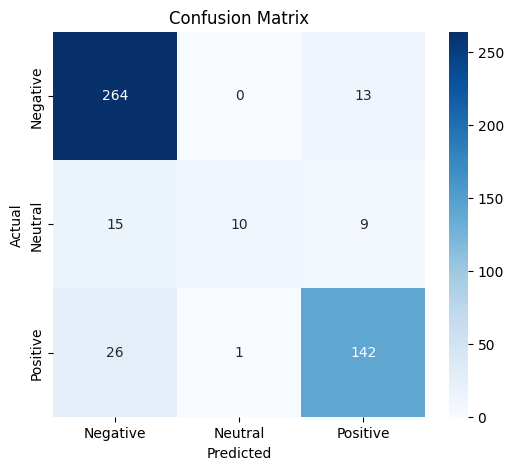

In [297]:
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [298]:
df_unlabeled = pd.read_csv("unlabeled_real_data.csv")
pred_list = []
conf_list = []

for review in df_unlabeled['TEXT']:
    processed = preprocess(review)
    X_review = tfidf.transform([processed])
    pred = svm.predict(X_review)[0]
    conf = svm.predict_proba(X_review).max()
    pred_list.append(pred)
    conf_list.append(f"{conf*100:.2f}%")

df_unlabeled['Predicted_Sentiment'] = pred_list
df_unlabeled['Confidence'] = conf_list
df_unlabeled.to_csv("unlabeled_predictions.csv", index=False)
print("Predictions saved to unlabeled_predictions.csv")

Predictions saved to unlabeled_predictions.csv


In [299]:
print("Training data distribution by sentiment:")
train_dist = pd.Series(y_train).value_counts()
print(train_dist)

Training data distribution by sentiment:
SENTIMENT
Negative    1106
Positive     676
Neutral      134
Name: count, dtype: int64


In [300]:
# Find negative reviews that contain positive words
negative_reviews = df[df['SENTIMENT'] == 'Negative']
positive_words = ['best', 'good', 'great', 'excellent', 'beautiful', 'amazing', 'wonderful']

mixed_negative = []
for idx, row in negative_reviews.iterrows():
    text = row['processed_text'].lower()
    if any(word in text for word in positive_words):
        mixed_negative.append({
            'text': row['TEXT'][:200],  # First 200 chars
            'processed': row['processed_text'][:100]
        })

print(f"Found {len(mixed_negative)} negative reviews containing positive words")
print("\nFirst 10 examples:")
for i, item in enumerate(mixed_negative[:10]):
    print(f"\n{i+1}. {item['text']}")

Found 221 negative reviews containing positive words

First 10 examples:

1. Ive traveled through KLIA countless times, and it has always impressed me with its cleanliness, smooth check-in process, and efficient security checks. The architecture, inspired by Malaysian, Islamic

2. not convenient to collect luggage if travelers are at the international flight building, as travelers have to take train to domestic flight building to retrieve their luggages which felt wasting of ti

3. A five-hour break costs 1,700 yuan, so Id better just eat a 23-yuan bowl of instant noodles. The cannellini noodles and fried rice inside are both very hard, so dont be offended. Only the curry chicke

4. I had the worst experience in this airport for travelling. This looks fancy but very old school. Restaurant not enough air con at night time. Sweating when eating Very confusing direction or procedure

5. (Emerites specifically from KL).. KL is a beautiful airport, super clean, very convenient with English 

In [301]:
# Find suspicious labels
for idx, row in df.iterrows():
    text = row['TEXT'].lower()
    label = row['SENTIMENT']
    
    # Negative reviews that seem positive
    if label == 'Negative' and ('best' in text or 'excellent' in text or 'amazing' in text):
        if not ('but' in text or 'however' in text or 'worst' in text):
            print(f"\nSUSPICIOUS NEGATIVE: {row['TEXT'][:150]}")
    
    # Positive reviews that seem negative  
    if label == 'Positive' and ('worst' in text or 'terrible' in text or 'awful' in text):
        if not ('not worst' in text or 'not terrible' in text):
            print(f"\nSUSPICIOUS POSITIVE: {row['TEXT'][:150]}")


SUSPICIOUS NEGATIVE: A five-hour break costs 1,700 yuan, so Id better just eat a 23-yuan bowl of instant noodles. The cannellini noodles and fried rice inside are both ver

SUSPICIOUS NEGATIVE: The immigration queue time at this airport is quite frustrating! There are no restaurants in the terminal after immigration. This airport is supposed 

SUSPICIOUS POSITIVE: First and Last Time! It's my first time in Malaysia, traveling from Abu Dhabi. As a UAE resident, I take pride in the excellent regulations we have. H

SUSPICIOUS POSITIVE: First and Last Time! It's my first time in Malaysia, traveling from Abu Dhabi. As a UAE resident, I take pride in the excellent regulations we have. H

SUSPICIOUS NEGATIVE: Organisation is not at best, it can't be compared with airports such as Doha, Singapore etc...the 2RM cashless charge for the train between the termin

SUSPICIOUS NEGATIVE: Flight display inside the departure area are quite small and hard to identify the flight untill you stand in fron